In [24]:
from utilities import *
from astropy.io import fits
import math 
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization
import os
import pdb
from scipy.optimize import curve_fit as cf
from astropy.modeling import powerlaws, fitting
from operator import add,sub,truediv
from matplotlib import gridspec
from astropy.table import QTable, vstack, hstack
import radio_beam
import sys
import regions
from astropy.wcs import WCS

plt.rcParams['figure.dpi'] = 300

source='DSiv'
fnum=fields[source]
central_pix=pixdict[source]
c2h5oh_sourcelocs={'DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/',
                   'DSiii':'/dec2024_3_try-close-to-FWZI/','DSiv':'/nov2024_1_firstrun_removesDS2exclusions/',
                   'DSVI':'/nov2024_1_removesDS2exclusions/'}
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/sep2023revolution/'#SgrB2S lives in the pacman_sep2023revolution folder, if we ever get to it
c2h5oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}'+c2h5oh_sourcelocs[source]

path_c2h5oh_trot=c2h5oh_datadir+'texmap_3sigma_allspw_withnans_weighted.fits'
path_error_c2h5oh_trot=c2h5oh_datadir+'texmap_error_allspw_withnans_weighted.fits'

hdu_c2h5oh_trot=fits.open(path_c2h5oh_trot)
data_c2h5oh_trot=hdu_c2h5oh_trot[0].data
error_c2h5oh_trot=fits.getdata(path_error_c2h5oh_trot)
cellsize=(np.abs(hdu_c2h5oh_trot[0].header['CDELT1']*u.deg)).to('arcsec')
pixtophysicalsize=(np.tan(cellsize)*jeff2024_dGC).to('AU')

data_ch3oh_radialtemperatures=np.genfromtxt(ch3oh_datadir+f'{source}_tex.txt')
error_ch3oh_radialtemperatures=np.genfromtxt(ch3oh_datadir+f'{source}_errtex.txt')

rdict={'SgrB2S':9500*u.AU,'DSi':8000*u.AU,'DSii':5500*u.AU,'DSiii':6000*u.AU,'DSiv':6000*u.AU,'DSv':7000*u.AU,
       'DSVII':6000*u.AU,'DSVIII':5400*u.AU,'DSIX':8000*u.AU}#1-6400,4-8500,5-4000,7-6600,S-12000

#To mititgate the inclusion of distant ethanol detections which can't be validated due to time contraints, I set
#a radius cutoff on the ethanol emission by using the by-eye flattening point of the ethanol's radially averaged column density - 1/29/2025
ethanol_rdict={'SgrB2S':'','DSi':6000*u.AU,'DSii':4000*u.AU,'DSiii':'','DSiv':6000*u.AU,'DSv':'',
       'DSVI':4000*u.AU,'DSVII':'','DSVIII':'','DSIX':''}

if source not in rdict.keys():
    r_phys=10000*u.AU
else:
    r_phys=rdict[source]#r*pixtophysicalsize.to('pc')
r=math.ceil((r_phys/pixtophysicalsize).to(''))

yy,xx=np.indices(data_c2h5oh_trot.shape)
rr=((xx-central_pix[1])**2+(yy-central_pix[0])**2)**0.5
mask=rr<r
radialdistance=(rr[mask]*pixtophysicalsize).value

In [25]:
c2h5oh_trots=hstack([radialdistance,data_c2h5oh_trot[mask]],table_names=['Distance','Trot'])
error_c2h5oh_trots=hstack([radialdistance,error_c2h5oh_trot[mask]],table_names=['Distance','Trot Error'])
ordered_c2h5oh_trots=c2h5oh_trots[c2h5oh_trots.argsort()]
ordered_error_c2h5oh_trots=error_c2h5oh_trots[error_c2h5oh_trots.argsort()]
ordered_radialdistances=list(set(ordered_c2h5oh_trots['col0_Distance']))
ordered_radialdistances.sort()

upperfillcutoff={'DSi':400,'DSii':310,'DSiv':600,'DSVI':450}#K
trotcutoff={'DSi':350,'DSii':300,'DSiv':500,'DSVI':315}

In [26]:
radial_average_trots=QTable()#names=['Distance','Trot'],units=['AU','K'])
ch3oh_trot_table=QTable([radialdistance,data_ch3oh_radialtemperatures,error_ch3oh_radialtemperatures],names=['Distance','Trot','Trot Error'])
radial_average_ch3oh=QTable()
for radial_bin in ordered_radialdistances:
    trots_in_radial_bin=ordered_c2h5oh_trots[np.where(ordered_c2h5oh_trots['col0_Distance']==radial_bin)[0]]
    error_trots_in_radial_bin=ordered_error_c2h5oh_trots[np.where(ordered_error_c2h5oh_trots['col0_Distance']==radial_bin)[0]]
    average_trot_in_bin=np.nanmean(trots_in_radial_bin['col0_Trot'])
    average_error_trot_in_bin=np.nanmean(error_trots_in_radial_bin['col0_Trot Error'])
    if radial_bin == 0 or len(np.where(np.isfinite(trots_in_radial_bin['col0_Trot'])==True)[0]) ==1:
        trotupperfill=average_trot_in_bin+average_error_trot_in_bin
        trotlowerfill=average_trot_in_bin-average_error_trot_in_bin
    else:
        trotupperfill=np.nanmax(trots_in_radial_bin['col0_Trot'])
        trotlowerfill=np.nanmin(trots_in_radial_bin['col0_Trot'])
    if average_trot_in_bin >= 3*average_error_trot_in_bin and average_trot_in_bin <= trotcutoff[source] and trotupperfill < upperfillcutoff[source] and radial_bin <= ethanol_rdict[source].value:
        table_to_append=QTable([{'Distance':radial_bin,'Trot':average_trot_in_bin,'Upper Trot':trotupperfill,'Lower Trot':trotlowerfill}])#,names=['Distance','Trot'],units=['AU','K'])
        radial_average_trots=vstack([radial_average_trots,table_to_append])

    ch3oh_in_radial_bin=ch3oh_trot_table[np.where(ch3oh_trot_table['Distance']==radial_bin)[0]]
    average_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['Trot'])
    average_error_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['Trot Error'])
    if radial_bin == 0:
        ch3oh_trotupperfill=average_ch3oh_trot_in_bin+average_error_ch3oh_trot_in_bin
        ch3oh_trotlowerfill=average_ch3oh_trot_in_bin-average_error_ch3oh_trot_in_bin
    else:
        ch3oh_trotupperfill=np.nanmax(ch3oh_in_radial_bin['Trot'])
        ch3oh_trotlowerfill=np.nanmin(ch3oh_in_radial_bin['Trot'])
    ch3oh_table_to_append=QTable([{'Distance':radial_bin,'Trot':average_ch3oh_trot_in_bin,'Upper Trot':ch3oh_trotupperfill,
                                   'Lower Trot':ch3oh_trotlowerfill}])
    radial_average_ch3oh=vstack([radial_average_ch3oh,ch3oh_table_to_append])
    #pdb.set_trace()
    #print(radial_bin)
    #pdb.set_trace()
#print(radial_average_trots)

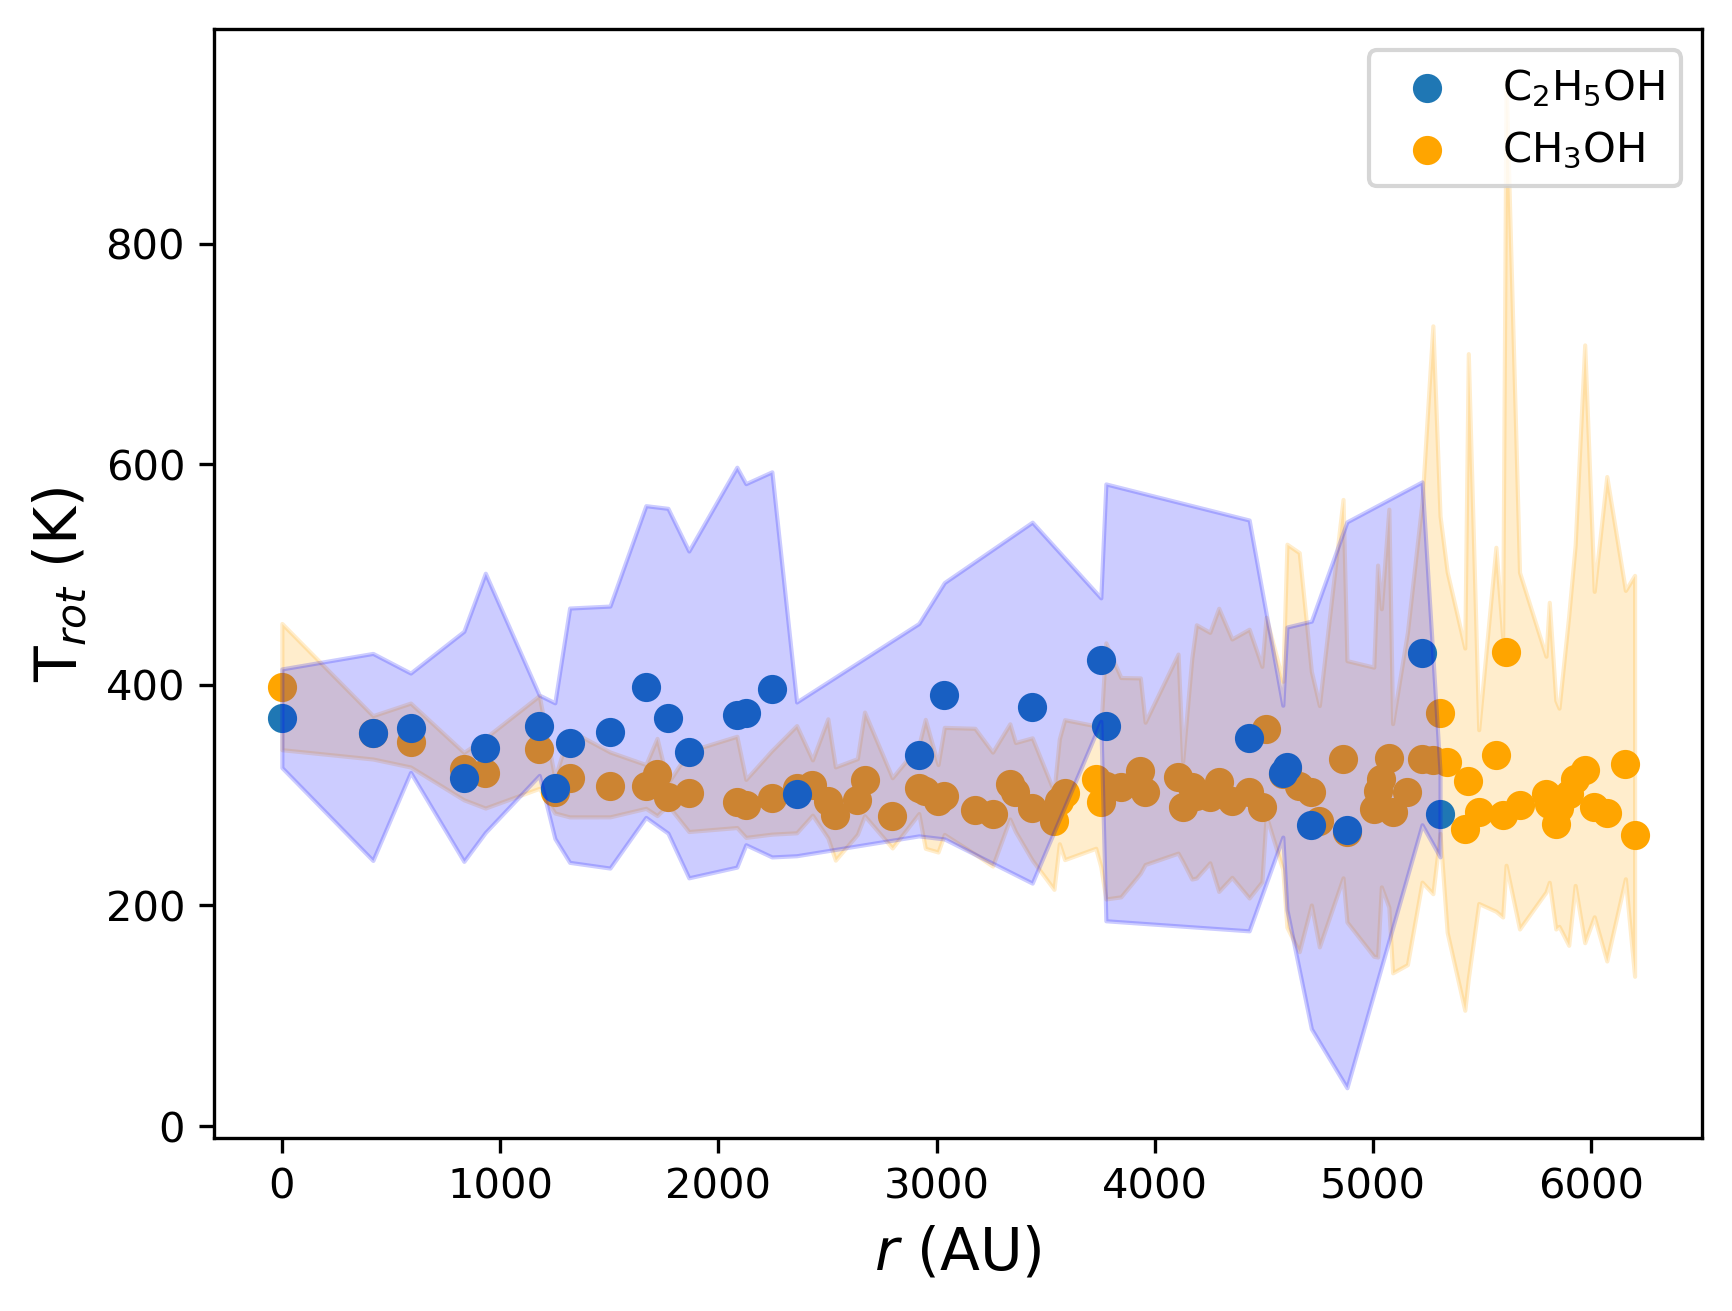

In [27]:
plt.figure()
plt.scatter(radial_average_trots['Distance'],radial_average_trots['Trot'],label=r'C$_2$H$_5$OH',zorder=20)
plt.fill_between(radial_average_trots['Distance'],radial_average_trots['Upper Trot'],radial_average_trots['Lower Trot'],alpha=0.2,color='blue',
                zorder=20)

plt.scatter(radial_average_ch3oh['Distance'],radial_average_ch3oh['Trot'],label=r'CH$_3$OH',color='orange')
plt.fill_between(radial_average_ch3oh['Distance'],radial_average_ch3oh['Upper Trot'],radial_average_ch3oh['Lower Trot'],alpha=0.2,color='orange')

plt.xlabel('$r$ (AU)',fontsize=14)
plt.ylabel('T$_{rot}$ (K)',fontsize=14)
plt.legend()

savefigpath=f'../plots/RadialTemperatureProfiles/{source}/ethanolradiuslimited_radial_temperature_profile.png'
plt.savefig(savefigpath)

plt.show()

In [30]:
radial_average_trots

Distance,Trot,Upper Trot,Lower Trot
float64,float64,float64,float64
0.0,267.62719951336936,305.15475798326753,230.09964104347122
417.0000000000415,258.5190663689107,270.6194593288083,242.6412964785604
589.7270555096394,241.3001442818879,257.8901021796056,226.18529448277818
834.000000000083,256.34119516985436,299.3549896829359,224.17878441984828
932.4403466175052,248.81213800617326,299.75436407191853,216.114022832681
1179.4541110192788,246.6555709598443,276.8273118083889,221.58713520770715
1251.0000000001246,248.22279076216796,295.1263191673752,217.94296771429504
1318.6697842903454,263.88906611749434,312.68130414164995,214.0761759980787
1503.514881868633,260.47197079117893,312.29201372489354,227.01568488494618


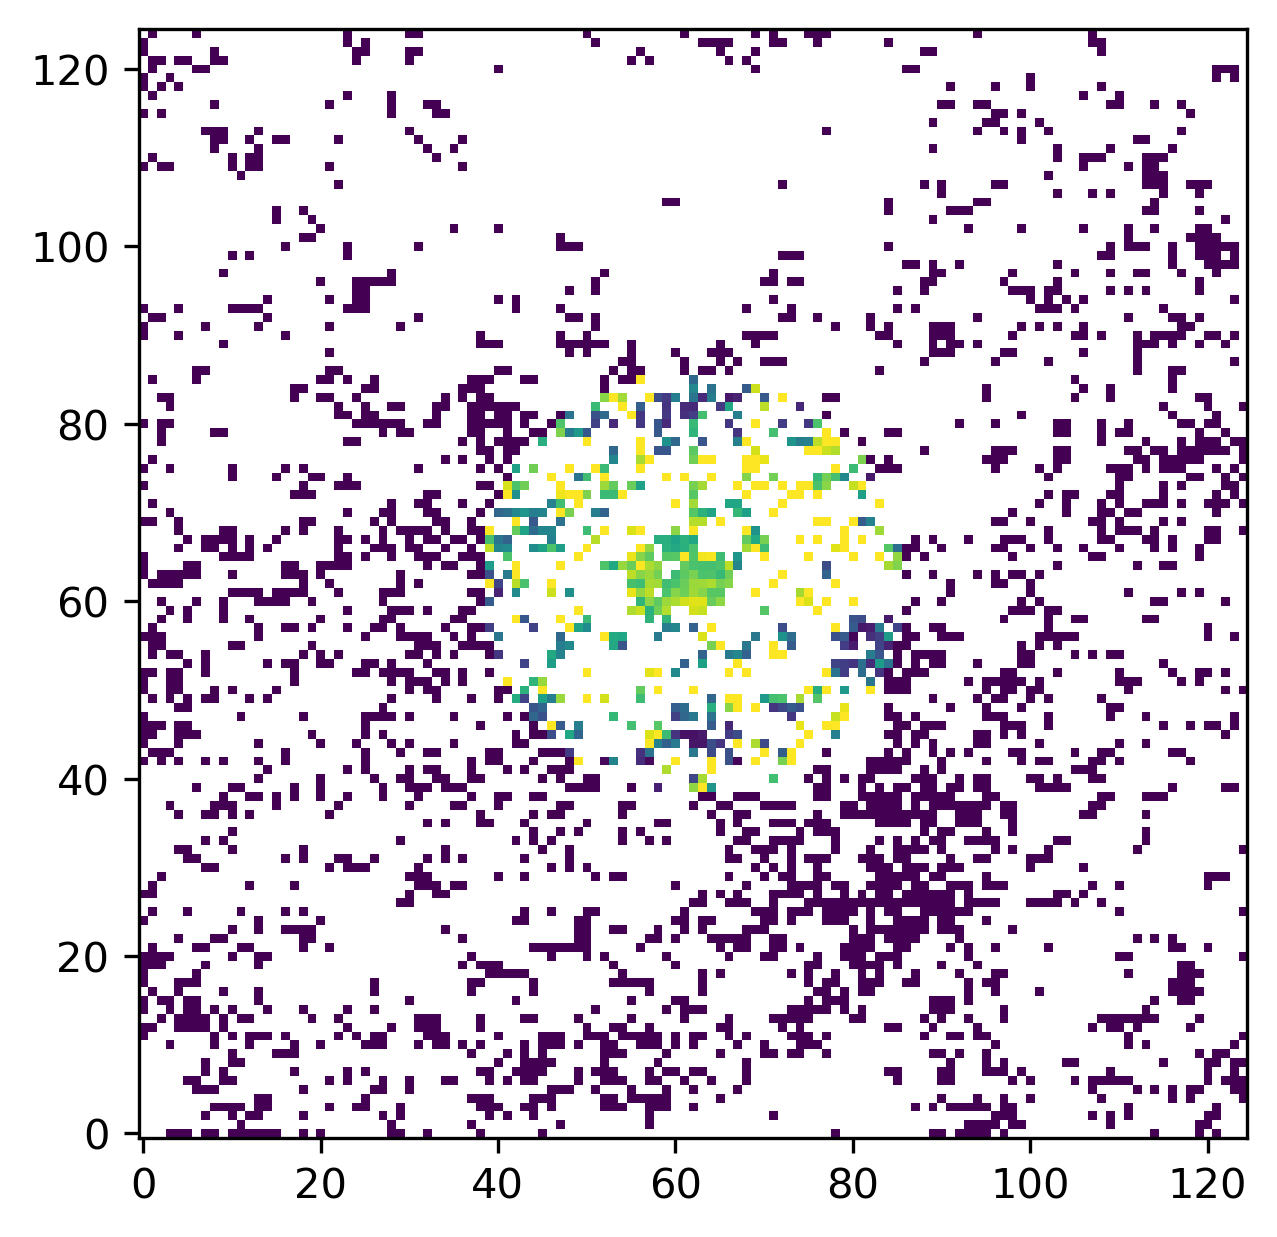

In [14]:
plt.imshow((data_c2h5oh_trot*mask),vmax=315,origin='lower')

In [33]:
pwd

'/blue/adamginsburg/d.jeff/SgrB2DS_COMAnalysis/scripts'

In [17]:
run bootstrap_makeradialtexdistr.py

Source: DSii
Figpath /blue/adamginsburg/d.jeff/repos/CH3OHTemps/figures/DSii//sep2023-2widerrefslab/ already exists.
Data directory /blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/pacman_sep2023revolution/ already exists.
417.0000000000415 AU
Center p: 211.17109287808958 K
physical radius: 5500.0 AU
[5808.13791159 5671.81320214 5563.47391474 5484.77866463 5437.01480594
 5421.         5437.01480594 5484.77866463 5563.47391474 5671.81320214
 5808.13791159 5793.1491436  5594.64207971 5421.         5274.67913716
 5158.00513765 5073.02395027 5021.34493936 5004.         5021.34493936
 5073.02395027 5158.00513765 5274.67913716 5421.         5594.64207971
 5793.1491436  5671.81320214 5437.01480594 5224.99502392 5038.63017099
 4880.85986277 4754.53152266 4662.20173309 4605.91554417 4587.
 4605.91554417 4662.20173309 4754.53152266 4880.85986277 5038.63017099
 5224.99502392 5437.01480594 5671.81320214 5610.16122763 5340.20561402
 5090.13369176 4863.0138803  4662.20173309 4491.22744915 435

divide by zero encountered in divide


In [18]:
radialdistance == centrtopix

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,